# Classification with Log Regression 

- we will attempt to predict the loan status using database bank 
- model : logistic regression, binary classification 
- some EDA + cleaning 
- expectations of low accuracy 

## Assemble the tools 

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
#import getpass
#password = getpass.getpass()

## running SQL query into df 

In [2]:
import getpass
password = getpass.getpass()

········


In [3]:
connection_string = 'mysql+pymysql://gloriaibars:' + password + '@127.0.0.1/bank'
engine = create_engine(connection_string)

In [4]:
query = """
SELECT 
    t.type,
    t.operation,
    t.amount AS t_amount,
    t.balance,
    t.k_symbol,
    l.amount AS l_amount,
    l.duration,
    l.payments,
    l.status
FROM
    trans t
        LEFT JOIN
    loan l ON t.account_id = l.account_id;
"""

In [5]:
data = pd.read_sql_query(query, engine)

In [6]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,VKLAD,700.0,700.0,,NaN,NaN,NaN,None
1,PRIJEM,VKLAD,900.0,900.0,,NaN,NaN,NaN,None
2,PRIJEM,VKLAD,1000.0,1000.0,,NaN,NaN,NaN,None
3,PRIJEM,VKLAD,600.0,600.0,,NaN,NaN,NaN,None
4,PRIJEM,VKLAD,400.0,400.0,,NaN,NaN,NaN,None


## EDA and data cleaning 
- remove nulls
- check the distribution of num var
- look for outliers 
- simplify categories - making them consistent, use UNKNOWN instead of blank
- check for multicollinearity and drop correlated columns (?)

In [7]:
data.isna().sum()

type              0
operation         0
t_amount          0
balance           0
k_symbol          0
l_amount     711938
duration     711938
payments     711938
status       711938
dtype: int64

In [8]:
len(data)

868019

In [9]:
# filter all the NaN
data = data[~data['duration'].isna()]

In [10]:
# reset index here 

In [11]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156081 entries, 62 to 868011
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   type       156081 non-null  object 
 1   operation  156081 non-null  object 
 2   t_amount   156081 non-null  float64
 3   balance    156081 non-null  float64
 4   k_symbol   156081 non-null  object 
 5   l_amount   156081 non-null  float64
 6   duration   156081 non-null  float64
 7   payments   156081 non-null  float64
 8   status     156081 non-null  object 
dtypes: float64(5), object(4)
memory usage: 11.9+ MB


In [13]:
# turning duration into categorical, becaus it comes in values of whole years (1,2,3,4,5)
data['duration'] = data['duration'].astype('object')

### cleaning categoricals

In [14]:
data['operation'].value_counts()

VYBER             70189
                  31337
PREVOD NA UCET    25796
VKLAD             22633
PREVOD Z UCTU      5336
VYBER KARTOU        790
Name: operation, dtype: int64

In [15]:
def clean_operation(x):
    x = x.lower()
    if 'vyber' in x:
        return 'vyber'
    elif 'prevod' in x:
        return 'prevod'
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

In [16]:
data['operation'] = data['operation'].apply(clean_operation)

In [17]:
data['k_symbol'].value_counts().index

Index(['', 'UROK', 'SLUZBY', 'SIPO', 'UVER', ' ', 'POJISTNE', 'SANKC. UROK'], dtype='object')

In [18]:
def clean_ksymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

In [19]:
data['k_symbol'] = data['k_symbol'].apply(clean_ksymbol)

In [20]:
data['k_symbol'].value_counts()

unknown        79925
UROK           31337
SLUZBY         23592
SIPO           10482
UVER            7744
POJISTNE        2412
SANKC. UROK      589
Name: k_symbol, dtype: int64

In [21]:
# filter data so that k_symbol is cleaned of 'POJISTINE', 'SANKC. UROK' or 'UVER'
data = data[~data['k_symbol'].isin(['POJISTINE', 'SANKC. UROK', 'UVER'])]

In [22]:
# reset index here 
data.reset_index(drop=True, inplace=True)


In [23]:
def clean_type(x):
    if 'PRI' in x:
        return 'PRIJEM'
    else:
        return x
    
data['type'] = data['type'].apply(clean_type)

In [24]:
data['type'].value_counts()

VYDAJ     83095
PRIJEM    59306
VYBER      5347
Name: type, dtype: int64

### check correlations for numerical columns

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
corr_matrix = data.corr()

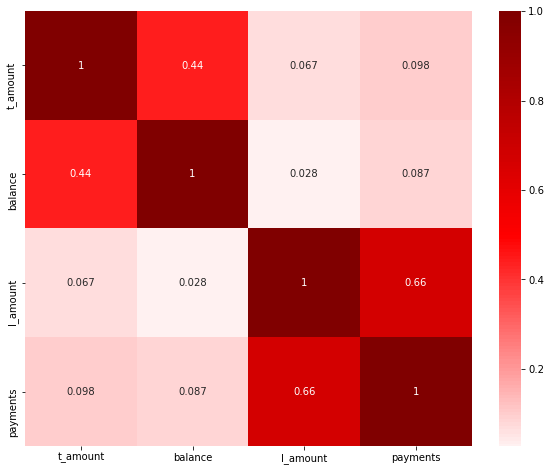

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix,
           cmap='seismic',
           center=0,
           annot=True,
           );

Note
* some high correlations between my features: Come back after first model validation and maybe drop highly correlated features

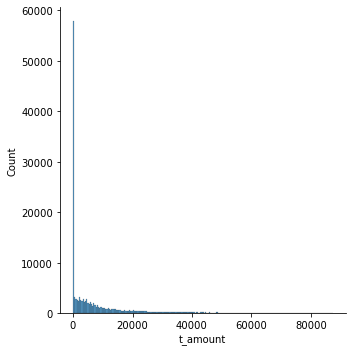

In [28]:
sns.displot(data['t_amount'])

In [29]:
data['t_amount'].describe()

count    147748.000000
mean       8022.366812
std       11980.002505
min           0.000000
25%         134.800000
50%        2700.000000
75%       10721.000000
max       87300.000000
Name: t_amount, dtype: float64

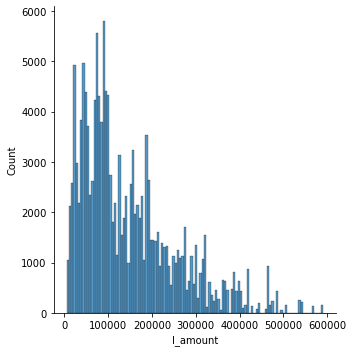

In [30]:
#fig, ax = plt.subplots(figsize=(12,8))
sns.displot(data['l_amount'])

In [31]:
data['l_amount'].describe()

count    147748.000000
mean     145810.456913
std      109587.181764
min        4980.000000
25%       64860.000000
50%      110736.000000
75%      200976.000000
max      590820.000000
Name: l_amount, dtype: float64

## Split data into num and cat for pre processing 

In [32]:
import numpy as np
from sklearn.preprocessing import Normalizer

X = data.select_dtypes(include = np.number)

In [33]:
X.head()

,t_amount,balance,l_amount,payments
0,44749.0,45549.0,79608.0,3317.0
1,1000.0,1000.0,52788.0,4399.0
2,1100.0,1100.0,21924.0,609.0
3,700.0,700.0,23052.0,1921.0
4,900.0,900.0,41904.0,3492.0


In [34]:
transformer = Normalizer()
transformer.fit(X)
x_normalized = transformer.transform(X)

In [35]:
x = pd.DataFrame(x_normalized, columns=X.columns)

In [36]:
x

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007
...,...,...,...,...
147743,0.000253,0.063358,0.997852,0.016631
147744,0.000426,0.096119,0.995232,0.016587
147745,0.000481,0.113176,0.993437,0.016557
147746,0.000706,0.152565,0.988156,0.016469


In [37]:
data['duration'].value_counts()

24.0    32595
12.0    31278
60.0    29797
48.0    27330
36.0    26748
Name: duration, dtype: int64

In [38]:
x

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007
...,...,...,...,...
147743,0.000253,0.063358,0.997852,0.016631
147744,0.000426,0.096119,0.995232,0.016587
147745,0.000481,0.113176,0.993437,0.016557
147746,0.000706,0.152565,0.988156,0.016469


In [39]:
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,prevod,44749.0,45549.0,unknown,79608.0,24.0,3317.0,A
1,PRIJEM,vklad,1000.0,1000.0,unknown,52788.0,12.0,4399.0,A
2,PRIJEM,vklad,1100.0,1100.0,unknown,21924.0,36.0,609.0,A
3,PRIJEM,vklad,700.0,700.0,unknown,23052.0,12.0,1921.0,A
4,PRIJEM,vklad,900.0,900.0,unknown,41904.0,12.0,3492.0,A
...,...,...,...,...,...,...,...,...,...
147743,PRIJEM,unknown,67.9,17036.9,UROK,268320.0,60.0,4472.0,C
147744,PRIJEM,unknown,187.2,42249.6,UROK,437460.0,60.0,7291.0,C
147745,PRIJEM,unknown,132.0,31046.4,UROK,272520.0,60.0,4542.0,C
147746,PRIJEM,unknown,271.6,58694.2,UROK,380160.0,60.0,6336.0,C


In [40]:
def goodbad(s):
    if s in ['A','C']:
        return 1 # good status 
    else:
        return 0 # bad status 
data['status_new']= list(map(goodbad,data['status']))


In [41]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status,status_new
0,PRIJEM,prevod,44749.0,45549.0,unknown,79608.0,24.0,3317.0,A,1
1,PRIJEM,vklad,1000.0,1000.0,unknown,52788.0,12.0,4399.0,A,1
2,PRIJEM,vklad,1100.0,1100.0,unknown,21924.0,36.0,609.0,A,1
3,PRIJEM,vklad,700.0,700.0,unknown,23052.0,12.0,1921.0,A,1
4,PRIJEM,vklad,900.0,900.0,unknown,41904.0,12.0,3492.0,A,1


In [42]:
data['status_new'].value_counts()
# this is an imbalanced data set - between the classes 
# majority class (good loans) 86%
# minority class (bad loans) 14%

# risk of amplification of the majority class 
# model struggles to identify bad loans 

1    129961
0     17787
Name: status_new, dtype: int64

    sampling techniques 
- addressing imbalance 
- poorly representative data
- small data sets 

oversampling - give the minority class more rows 
undersampling - give the majority class less rows 

tomek links 
smote 
random under sampling random oversampling 

In [43]:
cat = data.select_dtypes(include = np.object)

C:\Users\glori\AppData\Local\Temp/ipykernel_14140/489165951.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat = data.select_dtypes(include = np.object)


In [44]:
cat

,type,operation,k_symbol,duration,status
0,PRIJEM,prevod,unknown,24.0,A
1,PRIJEM,vklad,unknown,12.0,A
2,PRIJEM,vklad,unknown,36.0,A
3,PRIJEM,vklad,unknown,12.0,A
4,PRIJEM,vklad,unknown,12.0,A
...,...,...,...,...,...
147743,PRIJEM,unknown,UROK,60.0,C
147744,PRIJEM,unknown,UROK,60.0,C
147745,PRIJEM,unknown,UROK,60.0,C
147746,PRIJEM,unknown,UROK,60.0,C


In [45]:
cat = cat.drop(['status'], axis=1)

In [46]:
cat.head()

,type,operation,k_symbol,duration
0,PRIJEM,prevod,unknown,24.0
1,PRIJEM,vklad,unknown,12.0
2,PRIJEM,vklad,unknown,36.0
3,PRIJEM,vklad,unknown,12.0
4,PRIJEM,vklad,unknown,12.0


In [47]:
categorical = pd.get_dummies(cat,
               drop_first=True,
               columns=['type', 'operation', 'k_symbol', 'duration'])

##  Modelling- candidate model 1 with Log Reg

In [48]:
x.head()

,t_amount,balance,l_amount,payments
0,0.438261,0.446096,0.779661,0.032486
1,0.018872,0.018872,0.996191,0.083016
2,0.050028,0.050028,0.997109,0.027697
3,0.030234,0.030234,0.995634,0.082970
4,0.021394,0.021394,0.996090,0.083007


In [49]:
categorical.head()

,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_unknown,duration_24.0,duration_36.0,duration_48.0,duration_60.0
0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,1,0,1,0,0
3,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,1,0,0,0,0


In [50]:
y = data['status_new']

In [51]:
y

0         1
1         1
2         1
3         1
4         1
         ..
147743    1
147744    1
147745    1
147746    1
147747    1
Name: status_new, Length: 147748, dtype: int64

In [52]:
#check the number of rows are the same 
len(x), len(y), len(data), len(categorical)

(147748, 147748, 147748, 147748)

next steps
- concatenate the numericals, categoricals together 
- split the data into train and test 
- import and train the model logistic regression (using X train, y train)
- test the model using Xtest and compare the results to ytest 
- evaluate the model using the confusion matrix and AUC 


In [53]:
X_full= pd.concat([x,categorical],axis=1)

In [54]:
X_full.head()

,t_amount,balance,l_amount,payments,type_VYBER,type_VYDAJ,operation_unknown,operation_vklad,operation_vyber,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UROK,k_symbol_unknown,duration_24.0,duration_36.0,duration_48.0,duration_60.0
0,0.438261,0.446096,0.779661,0.032486,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0.018872,0.018872,0.996191,0.083016,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0.050028,0.050028,0.997109,0.027697,0,0,0,1,0,0,0,0,1,0,1,0,0
3,0.030234,0.030234,0.995634,0.082970,0,0,0,1,0,0,0,0,1,0,0,0,0
4,0.021394,0.021394,0.996090,0.083007,0,0,0,1,0,0,0,0,1,0,0,0,0


In [55]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147748 entries, 0 to 147747
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   t_amount           147748 non-null  float64
 1   balance            147748 non-null  float64
 2   l_amount           147748 non-null  float64
 3   payments           147748 non-null  float64
 4   type_VYBER         147748 non-null  uint8  
 5   type_VYDAJ         147748 non-null  uint8  
 6   operation_unknown  147748 non-null  uint8  
 7   operation_vklad    147748 non-null  uint8  
 8   operation_vyber    147748 non-null  uint8  
 9   k_symbol_SIPO      147748 non-null  uint8  
 10  k_symbol_SLUZBY    147748 non-null  uint8  
 11  k_symbol_UROK      147748 non-null  uint8  
 12  k_symbol_unknown   147748 non-null  uint8  
 13  duration_24.0      147748 non-null  uint8  
 14  duration_36.0      147748 non-null  uint8  
 15  duration_48.0      147748 non-null  uint8  
 16  du

In [56]:
cat.head()

,type,operation,k_symbol,duration
0,PRIJEM,prevod,unknown,24.0
1,PRIJEM,vklad,unknown,12.0
2,PRIJEM,vklad,unknown,36.0
3,PRIJEM,vklad,unknown,12.0
4,PRIJEM,vklad,unknown,12.0


In [57]:
from sklearn.linear_model import LogisticRegression #model
from sklearn.model_selection import train_test_split # tt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix # eval
from sklearn.metrics import classification_report #eval
from sklearn.metrics import accuracy_score #eval

In [58]:
# define the model 
lr=LogisticRegression(max_iter=400)

In [59]:
#seed 
X_train, X_test, y_train, y_test=train_test_split(X_full,y, test_size=0.3, random_state=40)

In [60]:
#fit the model to our training data set 
lr.fit(X_train,y_train)

LogisticRegression(max_iter=400)

## Evaluating candidate model 1 

In [61]:
y_pred=lr.predict(X_test)
# for our test data make some pred of y (using the trained model)

In [62]:
accuracy_score(y_test,y_pred)
# comparing each actual y to each pred y for the test data set 

0.8823011844331641

In [63]:
# we were right 88% of the time in classifying our status 
confusion_matrix(y_test,y_pred)

array([[  210,  5121],
       [   96, 38898]], dtype=int64)

In [64]:
from sklearn.metrics import plot_confusion_matrix 

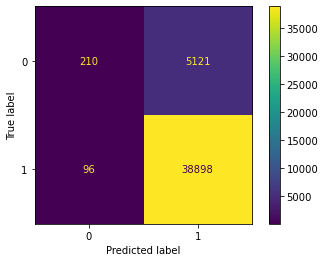

In [65]:
plot_confusion_matrix(lr, X_test, y_test)

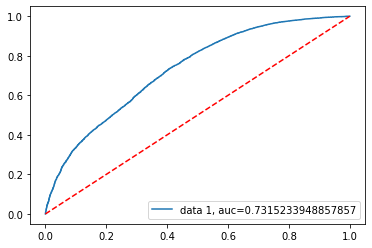

In [66]:
#AUC - area under the curve 

import sklearn.metrics as metrics

y_pred_proba = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0,1],[0,1],'r--') # add the red line to the middle of the plot 
plt.legend(loc=4)
plt.show()

## Data Imbalance - review and possible mitigation 

In [67]:
data['status_new'].value_counts()

1    129961
0     17787
Name: status_new, dtype: int64

In [68]:
y.value_counts()

1    129961
0     17787
Name: status_new, dtype: int64

In [69]:
y_train.value_counts()

1    90967
0    12456
Name: status_new, dtype: int64

In [70]:
y_test.value_counts()

1    38994
0     5331
Name: status_new, dtype: int64

### SMOTE oversampling technique 

In [71]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()

In [72]:
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

In [73]:
len(X_train)

103423

In [74]:
len(X_train_sm)

181934

In [75]:
y_train.value_counts()

1    90967
0    12456
Name: status_new, dtype: int64

In [76]:
y_train_sm.value_counts()

1    90967
0    90967
Name: status_new, dtype: int64

In [77]:
# fit to train - smote 
lr.fit(X_train_sm,y_train_sm)

LogisticRegression(max_iter=400)

In [78]:
#create new predictions based on smote train 
y_pred_sm=lr.predict(X_test)

In [79]:
#accuracy using smote for train 
accuracy_score(y_test,y_pred_sm)

0.6409701071630005

In [80]:
#conf matrix for smote model C2 
confusion_matrix(y_test,y_pred_sm)

array([[ 3628,  1703],
       [14211, 24783]], dtype=int64)

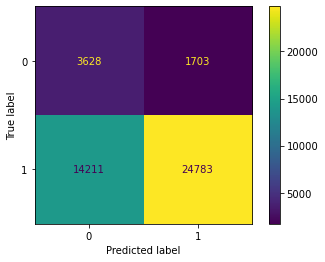

In [81]:
plot_confusion_matrix(lr, X_test, y_test)

### Tomek links undersampling 

In [82]:
#import tomeklinks 
from imblearn.under_sampling import TomekLinks 
tomek=TomekLinks(sampling_strategy='majority')
#warning, heavy algorithm ! will slow your computer down 

In [83]:
# apply tomek to train data set only
X_train_tk, y_train_tk = tomek.fit_resample(X_train,y_train)

In [84]:
y_train_tk.value_counts()

1    86028
0    12456
Name: status_new, dtype: int64

In [85]:
y_train.value_counts()

1    90967
0    12456
Name: status_new, dtype: int64

In [86]:
lr.fit(X_train_tk,y_train_tk)

LogisticRegression(max_iter=400)

In [87]:
y_pred_tk=lr.predict(X_test)

In [88]:
accuracy_score(y_test,y_pred_tk)

0.8827072758037225

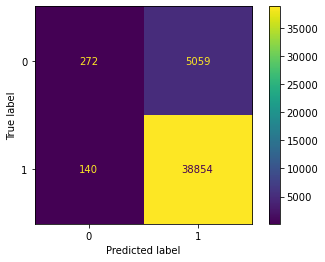

In [89]:
plot_confusion_matrix(lr, X_test, y_test)

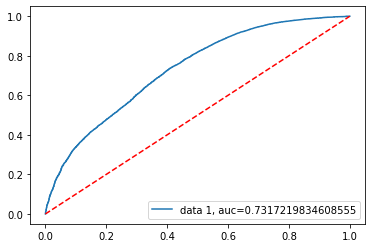

In [90]:
y_pred_proba_tk = lr.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_tk)
auc = metrics.roc_auc_score(y_test, y_pred_proba_tk)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0,1],[0,1],'r--') # add the red line to the middle of the plot 
plt.legend(loc=4)
plt.show()

## Appendix 

### Explanation for dummie variables

In [91]:
import random
gender_lst = ['M', 'F']

In [92]:
df_example = pd.DataFrame({'gender':[random.choice(gender_lst) for i in range(20)]})

In [93]:
pd.get_dummies(df_example, columns=['gender'], drop_first=True)

,gender_M
0,1
1,1
2,0
3,0
4,1
5,0
6,1
7,0
8,1
9,0


Recall the meaning of A, B, C, D

* **A**: contract finished, no problems (we have a lot of them)
* **B**: contract finished, loan not payed
* **C**: running contract, OK so far (we have a lot of them)
* **D**: running contract, client in debt